# FOCAST TIMESERIES DATA

Từ quan sát trên, dường như ta có thể dự đoán được nhiệt độ của các giờ trong những ngày tiếp theo. Còn việc dự đoán AQI thì khó hơn khi ta chưa thấy được đặc điểm nhất định của AQI.

In [14]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv('../aqi_VietNam.csv',encoding = 'utf-8',sep = '\t')
data.head()

,Tỉnh,Vị trí,Nhiệt độ,Độ ẩm,Tốc độ gió,Áp suất,Ngày giờ,VN_AQI,CO,NO2,O3,PM-10,PM-2-5,SO2,Miền
0,Gia Lai,"('13.998599', '107.996482')",28.77,57,2.72,1010,03/07/2021 08:00,50,4.0,10.0,5.0,36.0,50.0,14.0,2
1,Ðà Nẵng,"('16.074', '108.217')",35.00,49,0.51,1007,03/07/2021 08:00,43,10.0,10.0,13.0,34.0,43.0,40.0,2
2,Cao Bằng,"('22.6782', '106.245')",29.54,80,0.63,1004,03/07/2021 08:00,74,NaN,0.0,1.0,57.0,74.0,1.0,1
3,Phú Thọ,"('21.33847', '105.3673')",31.92,65,1.54,1003,03/07/2021 08:00,30,NaN,9.0,10.0,17.0,30.0,NaN,1
4,Thái Nguyên,"('21.593151', '105.8431043')",31.88,67,0.77,1003,03/07/2021 08:00,45,6.0,15.0,NaN,43.0,45.0,15.0,1


In [16]:
df = data[data['Tỉnh'] == 'Gia Lai']
df.loc[:,['Ngày giờ']]= pd.to_datetime(df['Ngày giờ'],format = "%d/%m/%Y %H:%M")
df = df.set_index('Ngày giờ')[['VN_AQI']]
df = df.sort_index()
df

,VN_AQI
Ngày giờ,
2021-07-03 00:00:00,24
2021-07-03 01:00:00,25
2021-07-03 02:00:00,26
2021-07-03 03:00:00,42
2021-07-03 04:00:00,37
...,...
2021-07-11 19:00:00,25
2021-07-11 20:00:00,25
2021-07-11 21:00:00,23


<AxesSubplot:xlabel='Ngày giờ'>

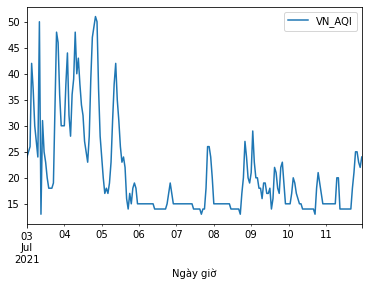

In [17]:
df.plot()

## Kiểm tra data có dừng hay không?
p-value > 0.05 => không dừng

p-value <= 0.05 là có dừng

In [19]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
ad_test(df['VN_AQI'])

1. ADF :  -1.3377582233632943
2. P-Value :  0.6117258084455933
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 200
5. Critical Values :
	 1% :  -3.463476079125
	 5% :  -2.876102355
	 10% :  -2.574532225


### Desompose

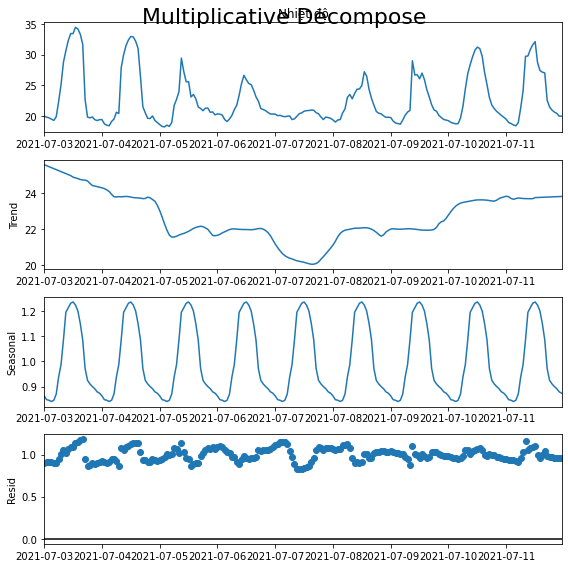

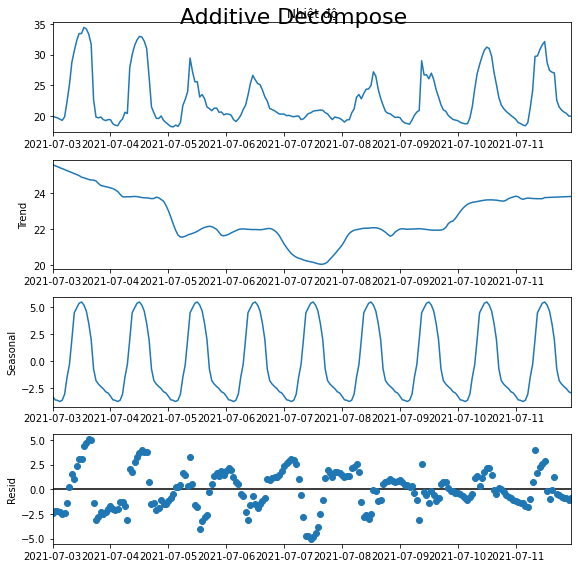

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Nhiệt độ'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Nhiệt độ'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### Chia train-test (test là 0h-23h ngày 11/7)

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df['Nhiệt độ'][:192]
test = df['Nhiệt độ'][192:]

### Sử dụng mô hình SARIMA

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        #try:
        temp_model = sm.tsa.statespace.SARIMAX(train,
                                         order = param,
                                         seasonal_order = param_seasonal,
                                         enforce_stationarity=True,
                                         enforce_invertibility=True)
        results = temp_model.fit()
        print("para{}x{}12 model - AIC:{}".format(param, param_seasonal, results.aic))
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
       # except:
        #    continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

para(0, 0, 0)x(0, 0, 0, 24)12 model - AIC:1749.419202596367
para(0, 0, 0)x(0, 0, 1, 24)12 model - AIC:1569.00277025772
para(0, 0, 0)x(0, 0, 2, 24)12 model - AIC:1438.808794143306
para(0, 0, 0)x(0, 1, 0, 24)12 model - AIC:802.4471892108782
para(0, 0, 0)x(0, 1, 1, 24)12 model - AIC:802.8339419605691
para(0, 0, 0)x(0, 1, 2, 24)12 model - AIC:781.0840296062717
para(0, 0, 0)x(0, 2, 0, 24)12 model - AIC:812.6456418793526
para(0, 0, 0)x(0, 2, 1, 24)12 model - AIC:748.9637123996858
para(0, 0, 0)x(0, 2, 2, 24)12 model - AIC:728.3199003546804
para(0, 0, 0)x(1, 0, 0, 24)12 model - AIC:1026.239575929888
para(0, 0, 0)x(1, 0, 1, 24)12 model - AIC:1026.4479454738107
para(0, 0, 0)x(1, 0, 2, 24)12 model - AIC:1006.2186399206
para(0, 0, 0)x(1, 1, 0, 24)12 model - AIC:802.0609304595555
para(0, 0, 0)x(1, 1, 1, 24)12 model - AIC:790.810240369002
para(0, 0, 0)x(1, 1, 2, 24)12 model - AIC:775.7522064685984
para(0, 0, 0)x(1, 2, 0, 24)12 model - AIC:711.0484084339721
para(0, 0, 0)x(1, 2, 1, 24)12 model - AIC:7

LinAlgError: LU decomposition error.

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 24), trend='n', enforce_stationarity=True, enforce_invertibility=True)

model_fit = model.fit(disp=False)
a = model_fit.predict(start = len(train), end = len(train)+24-1)

<AxesSubplot:xlabel='Ngày giờ'>

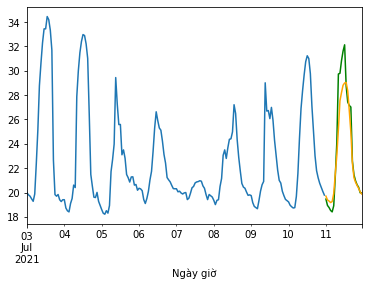

In [11]:
train.plot()
test.plot(color = 'green')
a.plot(color ='orange')

In [12]:
a = [1,2,3]
a[:-2]

[1]